## Librarires

In [ ]:
!nvidia-smi

Mon Apr 10 16:27:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |   1801MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.72 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.9/78.2 GB disk)


## Install Supervision

In [ ]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


## Download data

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz" -O subway.mp4 && rm -rf /tmp/cookies.txt

/content
--2023-04-10 15:05:40--  https://docs.google.com/uc?export=download&confirm=t&id=1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz
Resolving docs.google.com (docs.google.com)... 108.177.96.138, 108.177.96.100, 108.177.96.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.96.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tnbjc86g5as364mmmtta0pga524bci7v/1681139100000/04309230031174164349/*/1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz?e=download&uuid=a121dfe4-83bc-4fae-a0ea-97b063b34390 [following]
--2023-04-10 15:05:40--  https://doc-00-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tnbjc86g5as364mmmtta0pga524bci7v/1681139100000/04309230031174164349/*/1qZ6ROKdzHbQiHdizKfYbecr9qquOQ0Cz?e=download&uuid=a121dfe4-83bc-4fae-a0ea-97b063b34390
Resolving doc-00-ag-docs.googleusercontent.com (doc-00-ag-docs.googleusercontent.com)... 108.177

In [ ]:
SUBWAY_VIDEO_PATH = f"{HOME}/subway.mp4"

## Detecting And Counting Number Of People Close To Trains (Safety Hazard)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 51.4MB/s]



0: 1280x736 12 persons, 1 dog, 1 backpack, 3 handbags, 1 teddy bear, 69.7ms
Speed: 1.1ms preprocess, 69.7ms inference, 40.6ms postprocess per image at shape (1, 3, 1280, 1280)


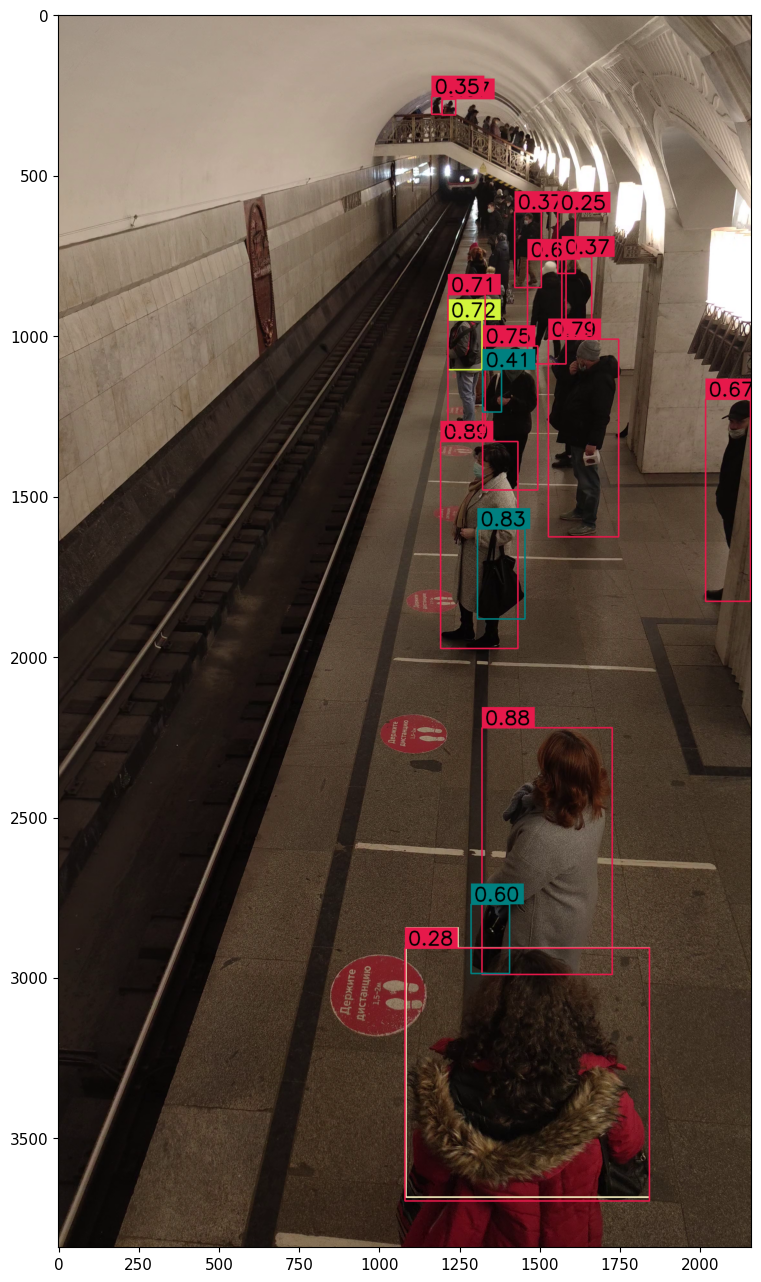

In [ ]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(SUBWAY_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

**NOTE:** As you can see earlier YOLO is super powerful and it is detecting every object but in our case we need to detect if the people are near the danger region or not therefore we must change our class for only detecting people


0: 1280x736 12 persons, 1 dog, 1 backpack, 3 handbags, 1 teddy bear, 33.8ms
Speed: 1.6ms preprocess, 33.8ms inference, 4.5ms postprocess per image at shape (1, 3, 1280, 1280)


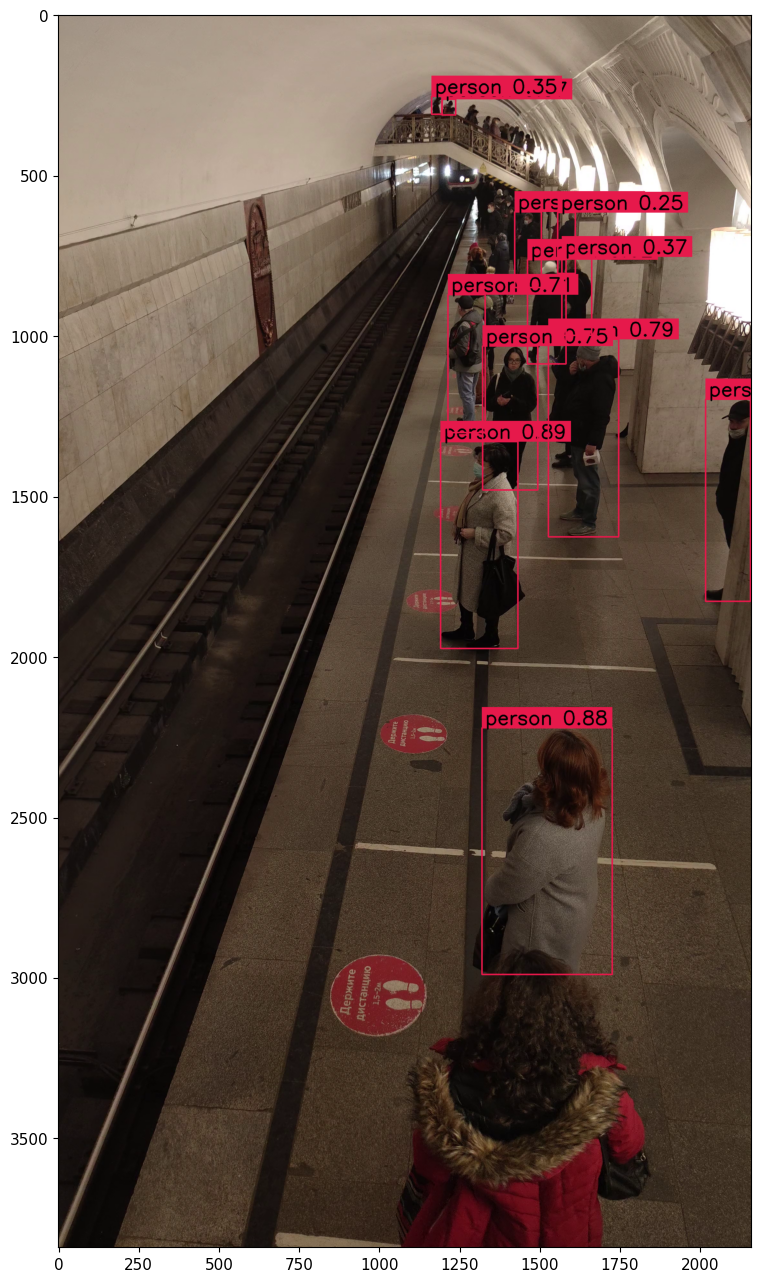

In [ ]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(SUBWAY_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[detections.class_id == 0]

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

**NOTE:** Now the next step is to add a polygon zone to vizualize the Danger Region Near Trains

In [ ]:
sv.VideoInfo.from_video_path(SUBWAY_VIDEO_PATH)

VideoInfo(width=2160, height=3840, fps=29, total_frames=1298)


0: 1280x736 12 persons, 1 dog, 1 backpack, 3 handbags, 1 teddy bear, 30.3ms
Speed: 1.3ms preprocess, 30.3ms inference, 2.4ms postprocess per image at shape (1, 3, 1280, 1280)


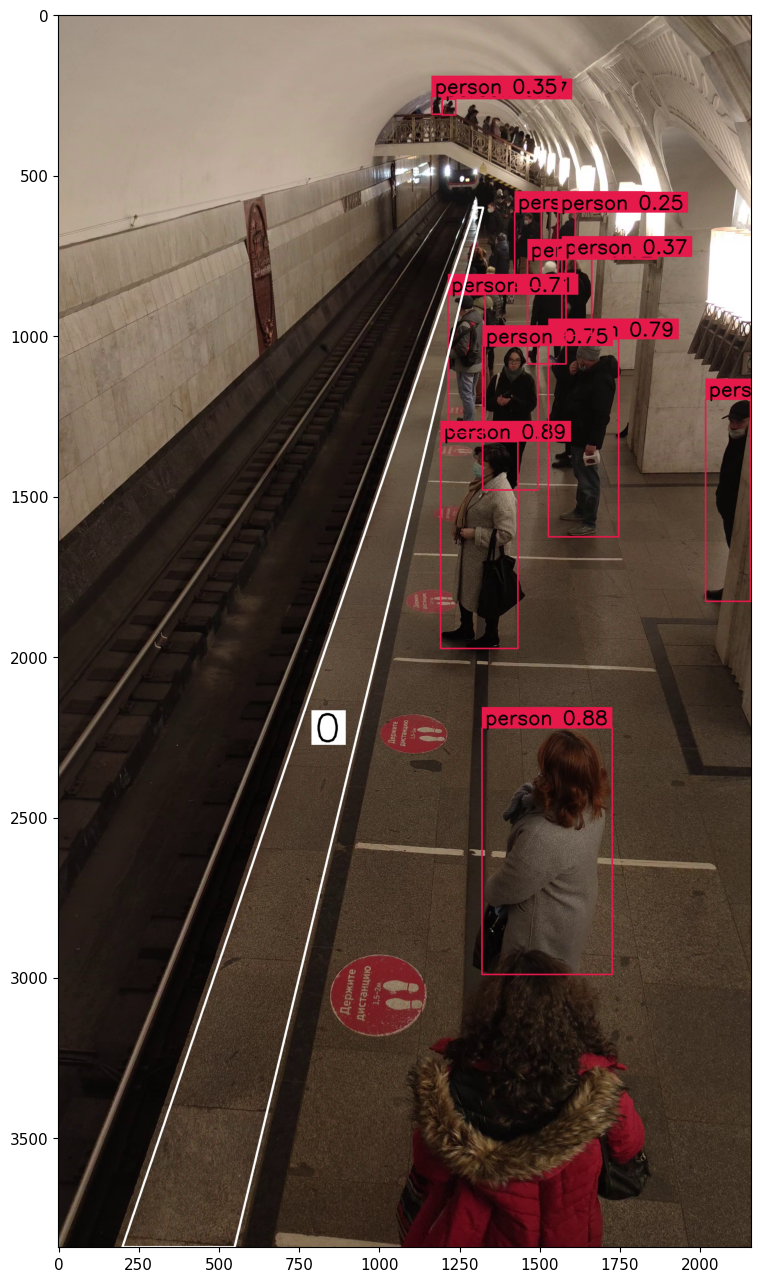

In [ ]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path(SUBWAY_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

# extract video frame
generator = sv.get_video_frames_generator(SUBWAY_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[detections.class_id == 0]
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

#Video Represenation

##RESULT: https://drive.google.com/file/d/1IbZxke4uDcHH4NOZpbeU33FgIUrNl7wO/view?usp=sharing

In [ ]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [200, 3840],
    [1300, 600],
    [1325, 600],
    [550, 3840]
])
video_info = sv.VideoInfo.from_video_path(SUBWAY_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    # detect
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_yolov8(results)
    detections = detections[detections.class_id == 0]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=SUBWAY_VIDEO_PATH, target_path=f"{HOME}/subway-result.mp4", callback=process_frame)

from IPython import display
display.clear_output()